In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [172]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [352]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True,min_df=0.03,ngram_range=(1,3))
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [353]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [354]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [355]:
def collect_with_target_value(data_frame, column, target_value):
    collected_values = data_frame.loc[data_frame[column] == target_value]
    return collected_values

In [356]:
def resample(data_frame, fraction):
    sampled_df = pd.DataFrame.sample(data_frame,frac=fraction, random_state= np.random.RandomState())
    return sampled_df

In [357]:
active_df = collect_with_target_value(table, 'binding', 1)
not_active_dfs = collect_with_target_value(table, 'binding',0)

In [358]:
not_active_dfs = not_active_dfs.reset_index()
active_df = active_df.reset_index()

In [359]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  precision_recall_fscore_support, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTEN
kf = KFold(n_splits=14)
mx_classifier = 0
curr_max = 0
mx_vectorizer = 0
vectorizer , feat_table = return_binary_vectorized_form(table.sequence)
sampler = SMOTEN(random_state=0)

# k_best_features = select_k_best_features(combined_features, combinded_train_binding, 0.13, vectorizer.get_feature_names_out())
# final_vectorizer ,final_train_data = return_binary_vectorized_form_with_vocab(combinded_train_sequence, k_best_features)
# final_test_data = final_vectorizer.transform(combined_test_sequence).toarray()

# score = []
# gnb = GaussianNB()

    # for tree in clfs:
# predict = gnb.fit(final_train_data,combinded_train_binding).predict(final_test_data)
# f = f1_score(combined_test_binding, predict)



In [360]:
vectorizer.get_feature_names_out()

array(['10044', '10075', '10081', ..., '99934', '99938', '99962'],
      dtype=object)

In [361]:
curr_max_sampled_sequence, o_sampled_binding = sampler.fit_resample(feat_table, table.binding)

/Users/bhabaranjanpanigrahi/miniforge3/envs/myenv/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(X_class[nn_indices[samples_indices]], axis=1).mode, axis=1


In [362]:
k_best_features = select_k_best_features(curr_max_sampled_sequence, o_sampled_binding, 0.13, vectorizer.get_feature_names_out())

training_seq, testing_sequence, training_binding, testing_binding = train_test_split(curr_max_sampled_sequence, o_sampled_binding,shuffle=True, stratify=o_sampled_binding, random_state=0, train_size=.70)

In [371]:
dt_clf = DecisionTreeClassifier(criterion='gini')
path = dt_clf.cost_complexity_pruning_path(training_seq, training_binding)
alphas, impurity = path.ccp_alphas, path.impurities
alphas = alphas[:-1]
clfs = []
for alpha in alphas:
    d_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    d_tree.fit(training_seq, training_binding)
    clfs.append(d_tree)

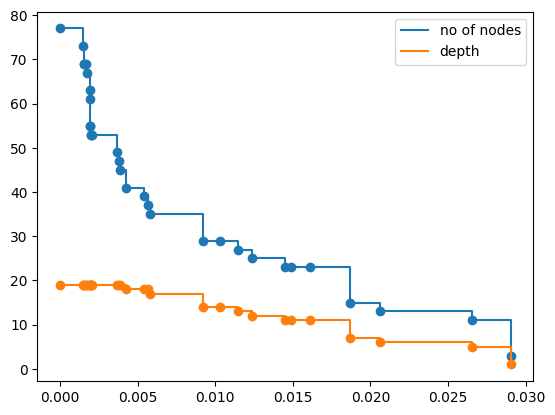

In [372]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(alphas,node_counts)
plt.scatter(alphas,depth)
plt.plot(alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

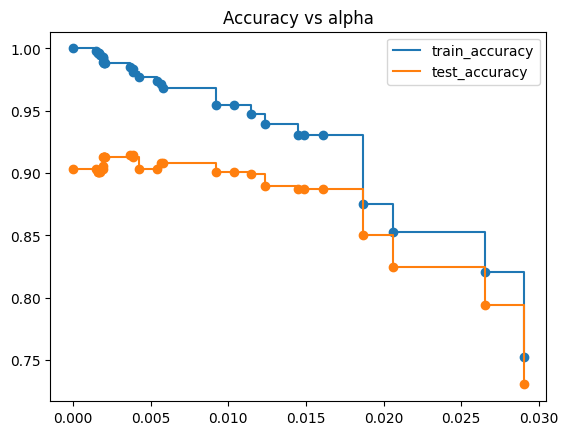

0.914848504793466
0.0036775106082036785


In [373]:
train_acc = []
test_acc = []
cur_max = 0
index = 0
for c in clfs:
    y_train_pred = c.predict(training_seq)
    y_test_pred = c.predict(testing_sequence)
    train_acc.append(f1_score(y_train_pred,training_binding,average='weighted'))
    test_acc.append(f1_score(y_test_pred,testing_binding,average='weighted'))
    if cur_max < test_acc[-1]:
        cur_max = test_acc[-1]
        alpha_max = alphas[len(test_acc)-1]
        index = len(test_acc)-1

plt.scatter(alphas,train_acc)
plt.scatter(alphas,test_acc)
plt.plot(alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()
print(cur_max)
print(alpha_max)

In [374]:
print(index)

13


array([0.        , 0.00097741, 0.00098248, 0.00148515, 0.00158416,
       0.00165017, 0.00191192, 0.00191419, 0.00192229, 0.00194353,
       0.00343234, 0.00356891, 0.00366703, 0.00373271, 0.00385039,
       0.00393364, 0.00431719, 0.00515035, 0.00568735, 0.00582909,
       0.00713125, 0.00740154, 0.00831979, 0.00972057, 0.01006568,
       0.01230279, 0.01334174, 0.01350119, 0.01398252, 0.01712839,
       0.02291119, 0.02325692])

In [437]:
predictions = pd.DataFrame(np.array(predict_test))

In [375]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])

In [376]:
unlabled_test_transformed = vectorizer.transform(table_test.sequence).toarray()

In [377]:
index

13

In [378]:
unlabled_predict_test = clfs[index].predict(unlabled_test_transformed)

In [379]:
unlabled_predict_test = np.array(unlabled_predict_test)

In [380]:
unlabled_predict_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [381]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], unlabled_predict_test))
outfile.close()